# Классификация

In [1]:
# Код нейронной сети в Keras!
###############################
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

In [2]:
(train_images,train_labels),(test_images,test_labels) = fashion_mnist.load_data()

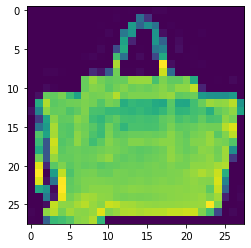

8


In [3]:
import matplotlib.pyplot as plt
n = 25025
plt.imshow(train_images[n,:,:])
plt.show()
print(train_labels[n])

In [4]:
# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Flatten the images.
train_images = train_images.reshape((-1, 784))
test_images = test_images.reshape((-1, 784))

print(train_images.shape) # (60000, 784)
print(test_images.shape)  # (10000, 784)

(60000, 784)
(10000, 784)


In [5]:
def madel_compile(number_neurons=128, number_layers=2, optimizer='adam'):
    
    Layers = [Dense(number_neurons, activation='relu', input_shape=(784,))]
    for k in range(number_layers-2): Layers.append(Dense(number_neurons, activation='relu'))
    Layers.append(Dense(10, activation='softmax'))
    #Build the model.
    model = Sequential(Layers)
    #Compile the model.
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy']
                )
    return model

def train_model(model, train_images, train_labels, test_images, test_labels, epochs=5):
    # Train the model.
    history_train = model.fit(train_images,
                              to_categorical(train_labels),
                              epochs=epochs,
                              batch_size=100,
                              validation_data = (test_images, to_categorical(test_labels)),
                              verbose=0
                              )

    return model, history_train

def predict_transform(y_test, predictions):
    y  = []
    pred = []
    for i in range(y_test.shape[1]):
        y.append(np.reshape(y_test[:, i:i+1], (1, y_test[:, i:i+1].shape[0]))[0])
        pred.append(np.reshape(predictions[:, i:i+1], (1, predictions[:,i:i+1].shape[0]))[0])
    
    return y, pred


In [6]:
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import (precision_score, f1_score, accuracy_score, \
                             classification_report, \
                             recall_score, confusion_matrix, roc_curve, \
                             precision_recall_curve, ConfusionMatrixDisplay, \
                             RocCurveDisplay,PrecisionRecallDisplay, roc_auc_score)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    
    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.arange(0.01, 1, 0.01):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'tresholds':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values[:10, :],
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])                                                                               

    
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))
    
    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1, bins=15)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8, bins=15)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

    return np.round(roc_auc_score(y_true_labels, y_predicted_probs), 3), \
            scores_table.values[0, 0], scores_table.values[0, 1], \
            scores_table.values[0, 2], scores_table.values[0, 3]

#--------------------------------------------------------------------------------
# Function to plot a Confusion Matrix
def Plot_Confusion_Matrix(CM,Title="Confusion Matrix"):
    GroupNames       = ["True Neg","False Pos","False Neg","True Pos"]
    GroupCounts      = ["{0:0.0f}".format(x) for x in CM.flatten()]
    GroupPercentages = ["{0:.2%}".format(x) for x in CM.flatten()/np.sum(CM)]
    
    Labels = [f"{x1}\n\n{x2}\n\n{x3}" for x1,x2,x3 in zip(GroupNames,GroupCounts,GroupPercentages)]
    Labels = np.asarray(Labels).reshape(2,2)
    
    FontSize = 12
    plt.figure(figsize=(6,5))
    Ax = sns.heatmap(CM, annot=Labels, fmt="", cmap="Blues")
    Ax.set_title(Title, fontsize=FontSize)
    Ax.set_xlabel("Predicted Values", fontsize=FontSize)
    Ax.set_ylabel("Actual Values", fontsize=FontSize)
    Ax.xaxis.set_ticklabels(["False","True"], fontsize=FontSize)
    Ax.yaxis.set_ticklabels(["False","True"], fontsize=FontSize)
    plt.show()
    return


def evaluate_preds(y_pred, y_test, tresholds):
    probs = y_pred >= tresholds
    print(classification_report(y_test, probs))
    Plot_Confusion_Matrix(confusion_matrix(y_test, probs))
    RocCurveDisplay.from_predictions(y_test, y_pred)
    PrecisionRecallDisplay.from_predictions(y_test, y_pred)
    plt.show()

# Практическое задание

Используем набор примеров fashion-MNIST

## 1.  Опишите - какой результата получен в нейросети в зависимости от:
  -  числа нейронов в слое(для 2-хслойной сети), 
  - числа слоев (2, 3, 5, 10) при близких размерах сети (близкое число тренируемых парметров).
  - фиксируйте для тренировочного и тестового набора метрики accuracy.

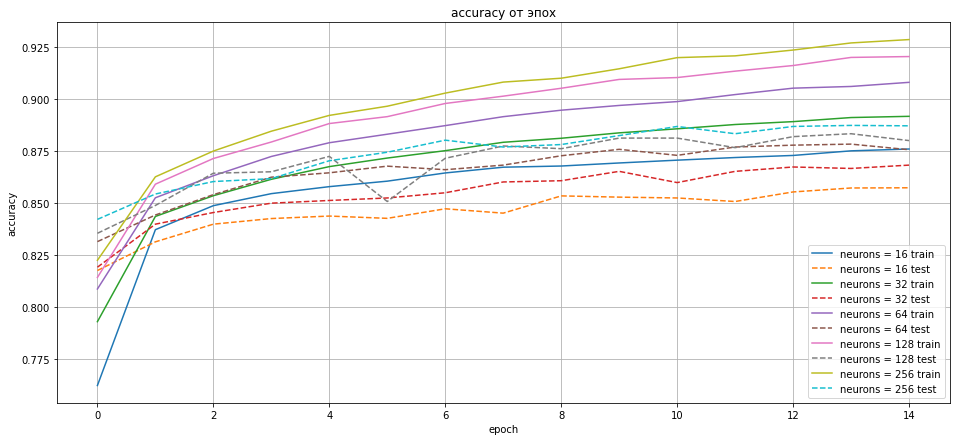

In [7]:
neurons = [16, 32, 64, 128, 256]

epochs = 15
# вектор для выводв результатов
epoch = np.arange(epochs)

plt.figure(figsize=(16,7))

for neuron in neurons:
    model = madel_compile(number_neurons=neuron)
    # проводим обучение модели 
    model, history_train = train_model(model, train_images, train_labels, test_images, test_labels, epochs)
    # картинки
    plt.plot(epoch,history_train.history['accuracy'],'-',label = f'neurons = {neuron} train')
    plt.plot(epoch,history_train.history['val_accuracy'],'--',label = f'neurons = {neuron} test')

plt.legend()
plt.grid('On')

plt.title('accuracy от эпох')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

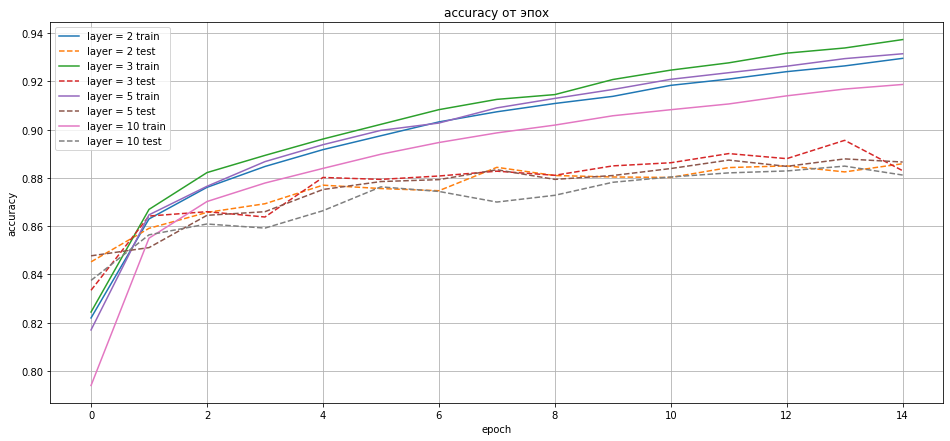

In [8]:
layers = [2, 3, 5, 10]

# вектор для выводв результатов
epoch = np.arange(epochs)

plt.figure(figsize=(16,7))

for layer in layers:
    model = madel_compile(number_neurons=256, number_layers=layer)
    # проводим обучение модели 
    model, history_train = train_model(model, train_images, train_labels, test_images, test_labels, epochs)
    # картинки
    plt.plot(epoch,history_train.history['accuracy'],'-',label = f'layer = {layer} train')
    plt.plot(epoch,history_train.history['val_accuracy'],'--',label = f'layer = {layer} test')

plt.legend()
plt.grid('On')

plt.title('accuracy от эпох')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

##2.  Проверьте работу разных оптимизаторов (SGD, Adam, RMSProp) для одной из моделей п.1.Фиксируйте для тренировочного и тестового набора метрики accuracy.

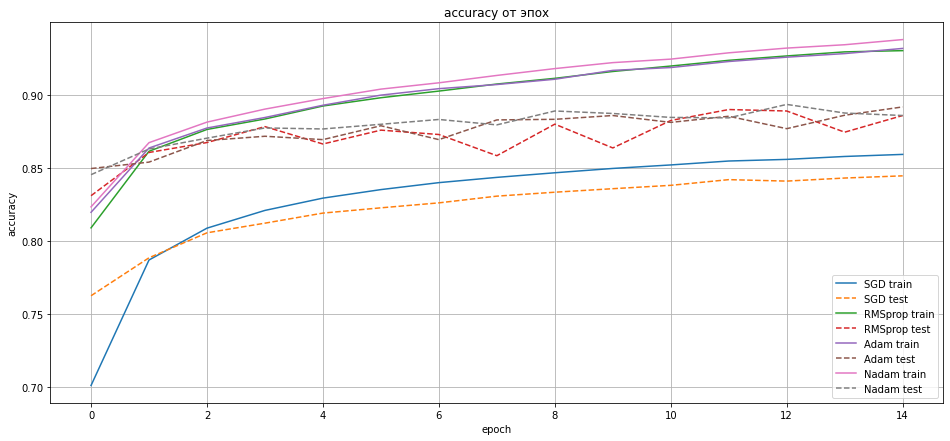

In [9]:
# создаем модель model
model_start = Sequential([
                      Dense(256, activation='relu', input_shape=(784,)),
                      Dense(10, activation='softmax'),
                      ])
# сохраняем ее веса (это начальная точка) model.save_weights('model.h5')
model_start.save_weights('model_start.h5')

# вектор для выводв результатов
#epoch = np.arange(epochs+1)
epoch = np.arange(epochs)

plt.figure(figsize=(16,7))

#opt_list = [keras.optimizers.SGD( ),keras.optimizers.Adam( ),keras.optimizers.Nadam( )]
for i_optim in ['SGD','RMSProp','adam','NAdam']:
    # создаем рабочую модель modeli куда будем загружать эти вес (она должна быть идентичной структуры)
    model = Sequential([
                      Dense(256, activation='relu', input_shape=(784,)),
                      Dense(10, activation='softmax'),
                      ])
    # загружаем веса modeli.load_weights('model.h5')
    model.load_weights('model_start.h5')
    # компилируем modeli с одним из оптимизаторов
    model.compile(
      optimizer=i_optim,
      loss='categorical_crossentropy',
      metrics=['accuracy'],
      )
    # вычисляем ошибку для modeli без обучения
    #history_0_train = model.evaluate(train_images, to_categorical(train_labels),verbose = 0)
    #history_0_test = model.evaluate(test_images, to_categorical(test_labels),verbose = 0)
    # проводим обучение модели 
    history_train = model.fit(
                               train_images,
                               to_categorical(train_labels),
                               epochs=epochs,
                               batch_size=100,
                               validation_data = (test_images, to_categorical(test_labels)),
                               verbose = 0
                            )
    # картинки
    #plt.plot(epoch,([history_0_train[1]]+history_train.history['accuracy']),'-',label = f'{model.optimizer.get_config()["name"]} train')
    #plt.plot(epoch,([history_0_test[1]]+history_train.history['val_accuracy']),'--',label = f'{model.optimizer.get_config()["name"]} test')
    plt.plot(epoch, history_train.history['accuracy'], '-', label = f'{model.optimizer.get_config()["name"]} train')
    plt.plot(epoch, history_train.history['val_accuracy'], '--',label = f'{model.optimizer.get_config()["name"]} test')

plt.legend()
plt.grid('On')

plt.title('accuracy от эпох')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## 3.Вывод: _На точность показаний в нашей модели влияют все протестированные параметры._ 

## 4. Для одного варианта сетей сформируйте матрицу ошибок по классам. Оцените качество модели по каждому классу отдельно (полнота , точность). Сделайте вывод.

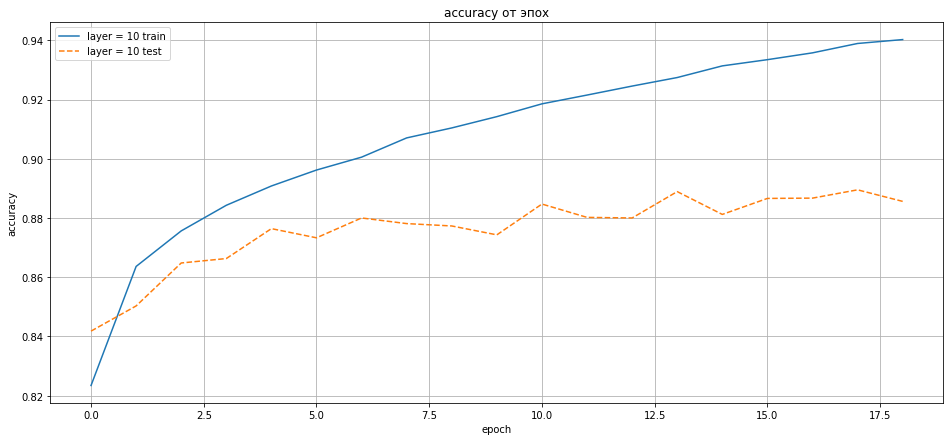

In [82]:
# вектор для выводв результатов
epochs = 19
epoch = np.arange(epochs)

plt.figure(figsize=(16,7))

model = madel_compile(number_neurons=256)
# проводим обучение модели 
model, history_train = train_model(model, train_images, train_labels, test_images, test_labels, epochs)
# картинки
plt.plot(epoch,history_train.history['accuracy'],'-',label = f'layer = {layer} train')
plt.plot(epoch,history_train.history['val_accuracy'],'--',label = f'layer = {layer} test')

plt.legend()
plt.grid('On')

plt.title('accuracy от эпох')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [83]:
(_,_),(images,labels) = fashion_mnist.load_data()
labels = list(labels)

In [84]:
# Получим результаты теста
y_test = to_categorical(test_labels)
predictions = model.predict(test_images)

y_test, predictions = predict_transform(y_test, predictions)

### 0 - класс

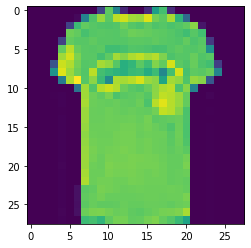

0


In [85]:
n = labels.index(0)
plt.imshow(images[n,:,:])
plt.show()
print(labels[n])

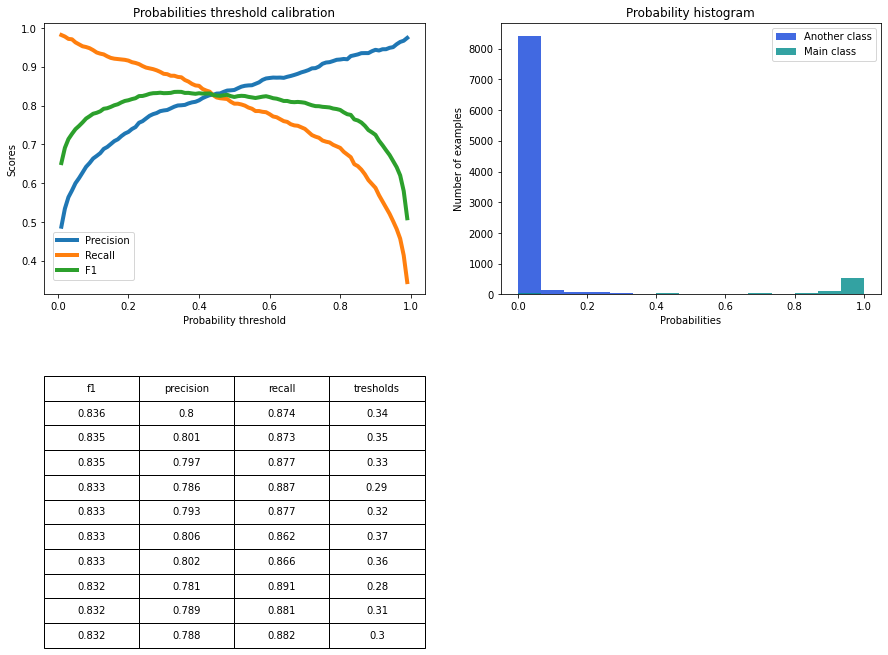

In [86]:
klass = labels[n]
roc_auc, f_score, precision, recall,  tresholds = show_proba_calibration_plots(predictions[klass], y_test[klass])

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      9000
         1.0       0.80      0.87      0.84      1000

    accuracy                           0.97     10000
   macro avg       0.89      0.92      0.91     10000
weighted avg       0.97      0.97      0.97     10000



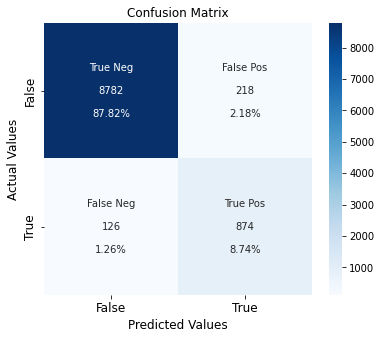

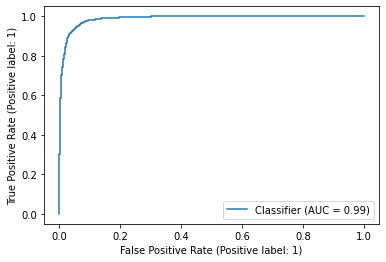

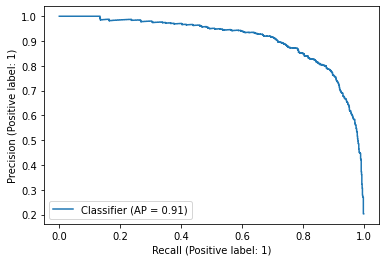

In [87]:
evaluate_preds(predictions[klass], y_test[klass], tresholds)

### 1 - класс

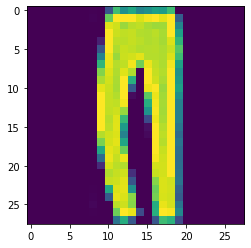

1


In [88]:
n = labels.index(1)
plt.imshow(images[n,:,:])
plt.show()
print(labels[n])

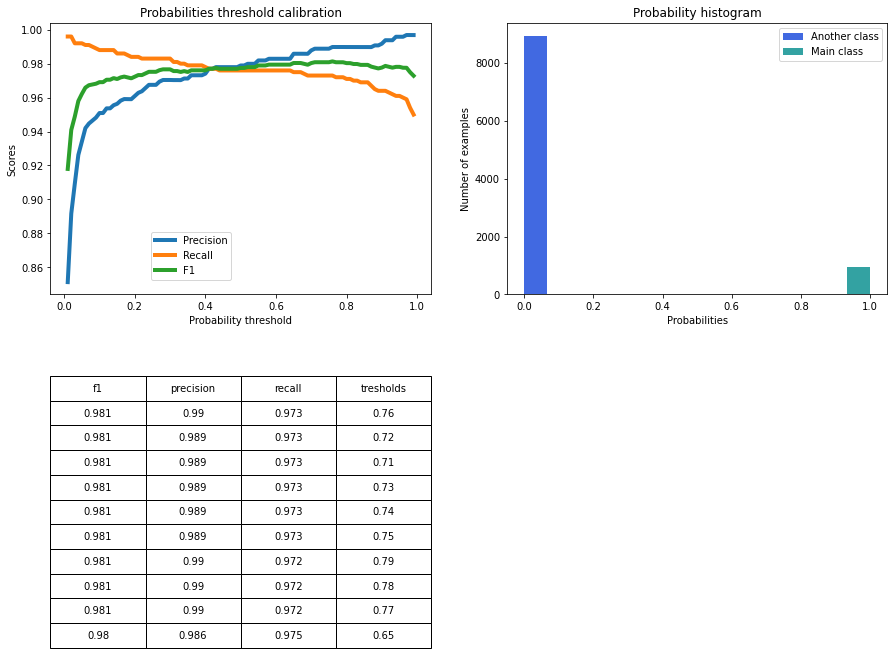

In [89]:
klass = labels[n]
roc_auc, f_score, precision, recall,  tresholds = show_proba_calibration_plots(predictions[klass], y_test[klass])

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9000
         1.0       0.99      0.97      0.98      1000

    accuracy                           1.00     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       1.00      1.00      1.00     10000



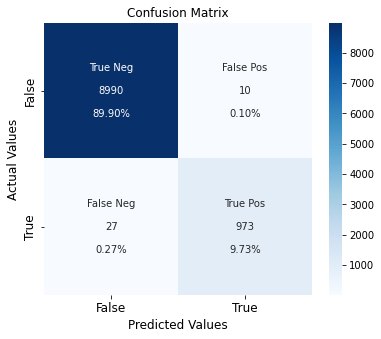

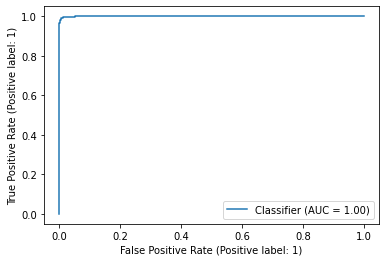

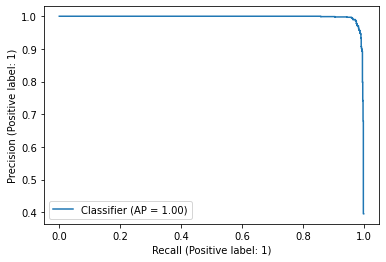

In [90]:
evaluate_preds(predictions[klass], y_test[klass], tresholds)

### 2 - класс

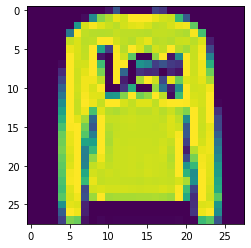

2


In [91]:
n = labels.index(2)
plt.imshow(images[n,:,:])
plt.show()
print(labels[n])

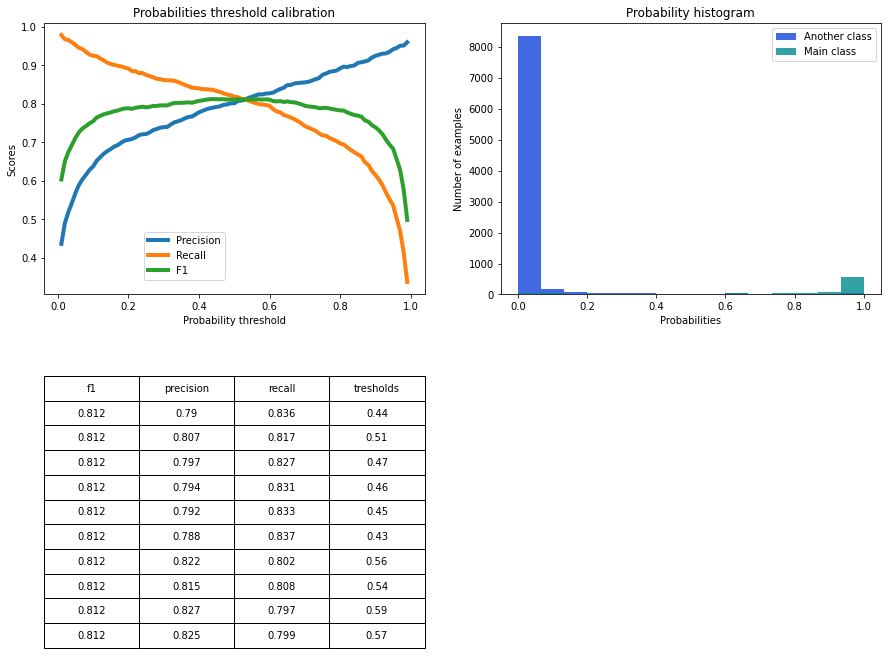

In [92]:
klass = labels[n]
roc_auc, f_score, precision, recall,  tresholds = show_proba_calibration_plots(predictions[klass], y_test[klass])

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      9000
         1.0       0.79      0.84      0.81      1000

    accuracy                           0.96     10000
   macro avg       0.89      0.91      0.90     10000
weighted avg       0.96      0.96      0.96     10000



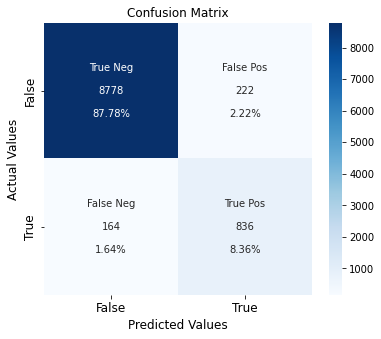

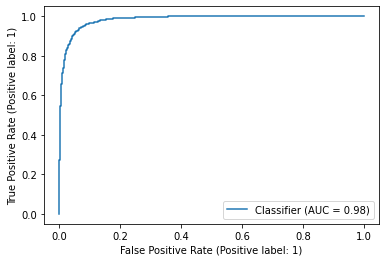

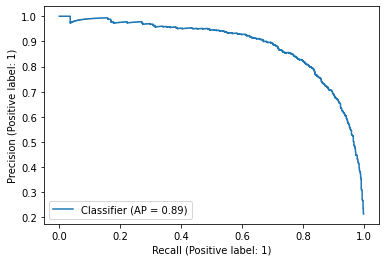

In [93]:
evaluate_preds(predictions[klass], y_test[klass], tresholds)

### 3 - класс

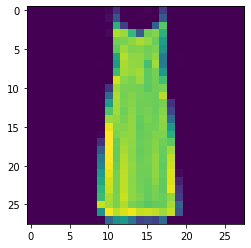

3


In [94]:
n = labels.index(3)
plt.imshow(images[n,:,:])
plt.show()
print(labels[n])

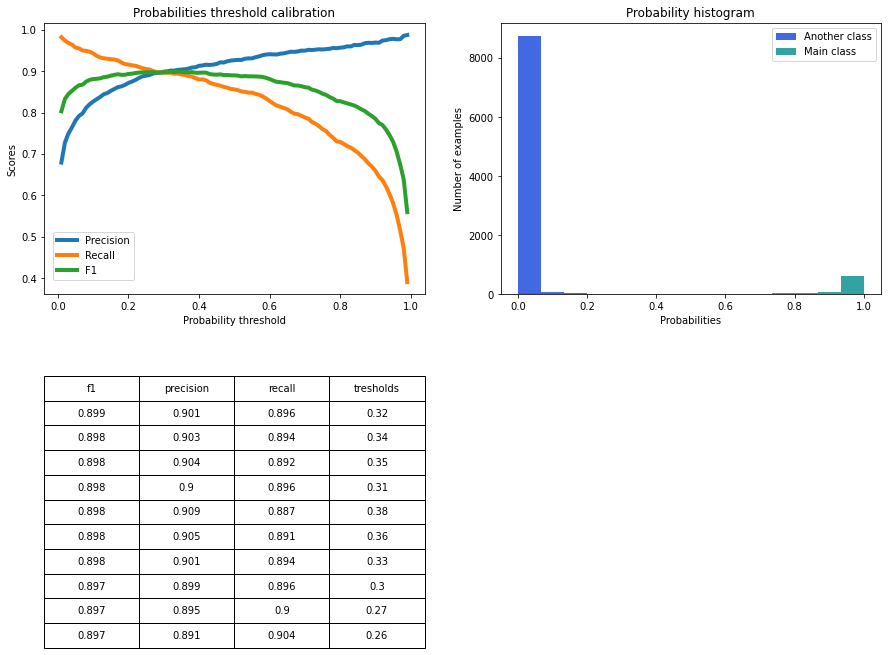

In [95]:
klass = labels[n]
roc_auc, f_score, precision, recall,  tresholds = show_proba_calibration_plots(predictions[klass], y_test[klass])

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      9000
         1.0       0.90      0.90      0.90      1000

    accuracy                           0.98     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.98      0.98      0.98     10000



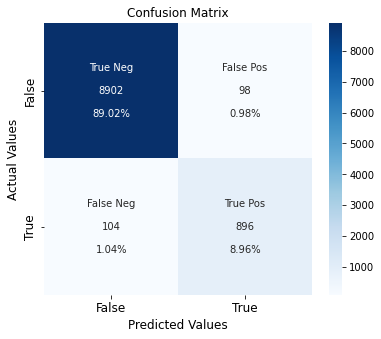

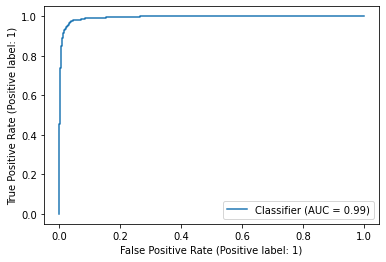

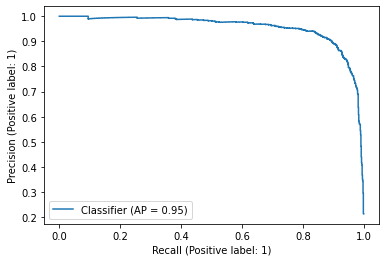

In [96]:
evaluate_preds(predictions[klass], y_test[klass], tresholds)

### 4 - класс

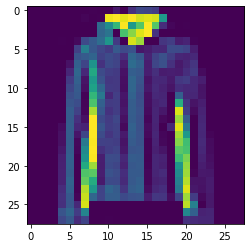

4


In [97]:
n = labels.index(4)
plt.imshow(images[n,:,:])
plt.show()
print(labels[n])

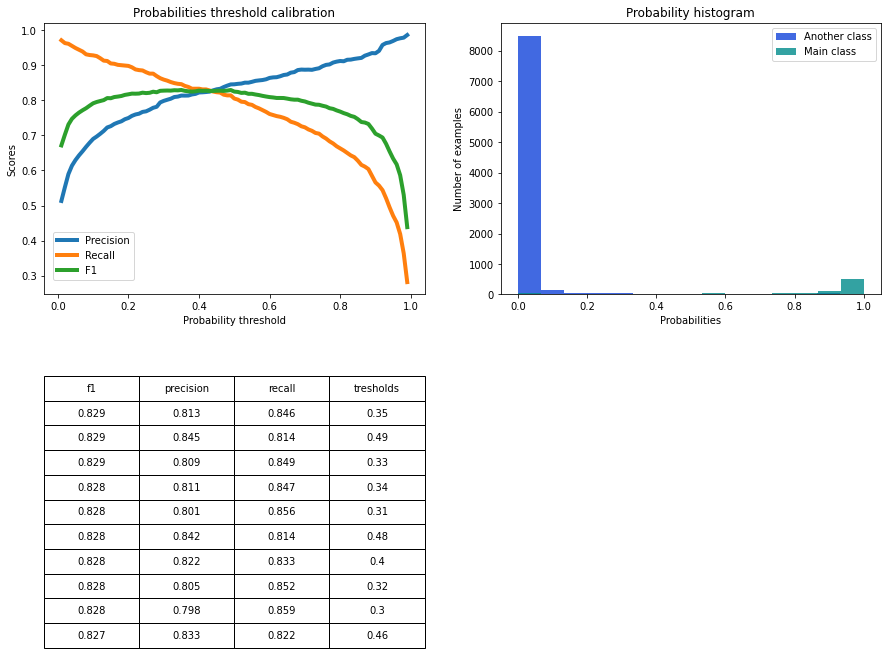

In [98]:
klass = labels[n]
roc_auc, f_score, precision, recall,  tresholds = show_proba_calibration_plots(predictions[klass], y_test[klass])

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      9000
         1.0       0.81      0.85      0.83      1000

    accuracy                           0.97     10000
   macro avg       0.90      0.91      0.91     10000
weighted avg       0.97      0.97      0.97     10000



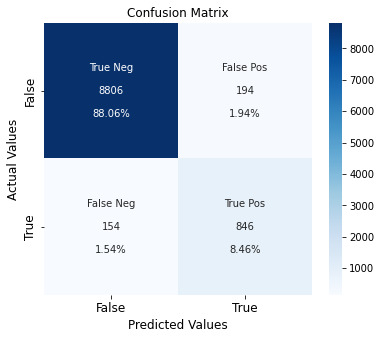

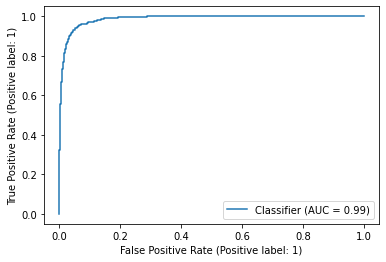

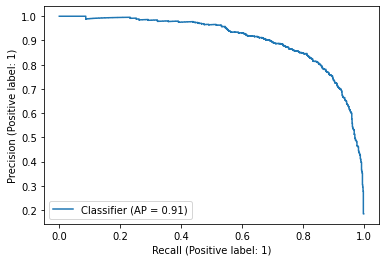

In [99]:
evaluate_preds(predictions[klass], y_test[klass], tresholds)

### 5 - класс

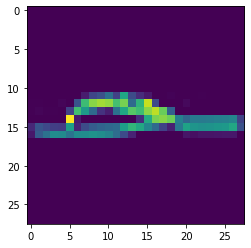

5


In [100]:
n = labels.index(5)
plt.imshow(images[n,:,:])
plt.show()
print(labels[n])

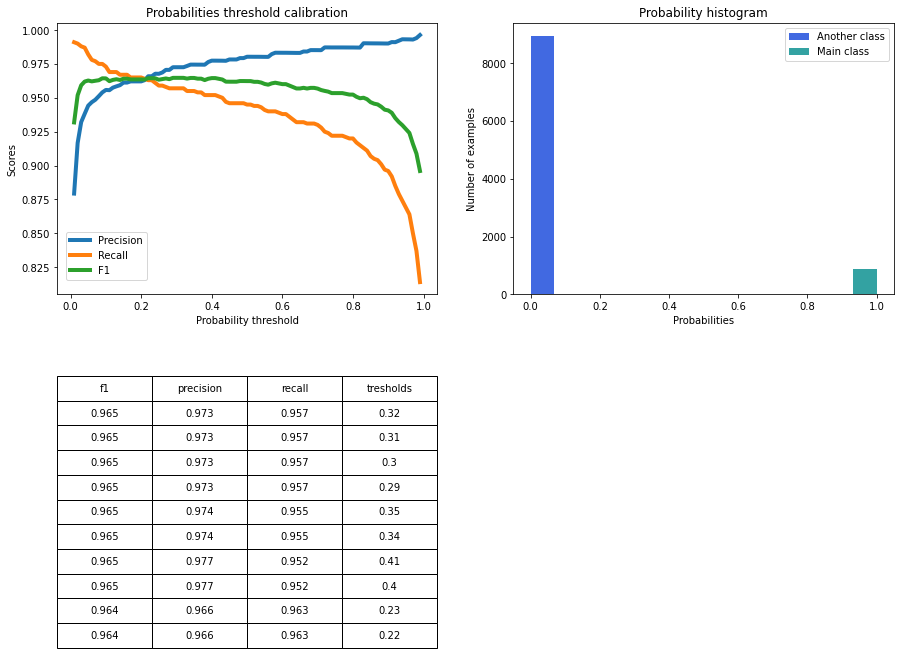

In [101]:
klass = labels[n]
roc_auc, f_score, precision, recall,  tresholds = show_proba_calibration_plots(predictions[klass], y_test[klass])

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9000
         1.0       0.97      0.96      0.96      1000

    accuracy                           0.99     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



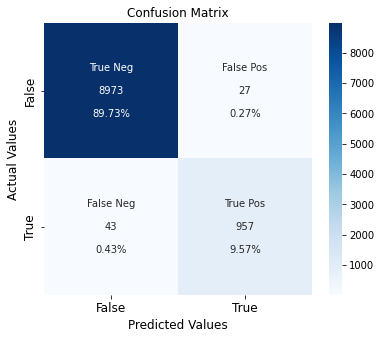

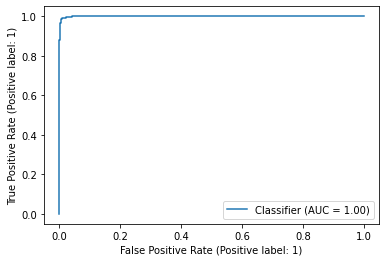

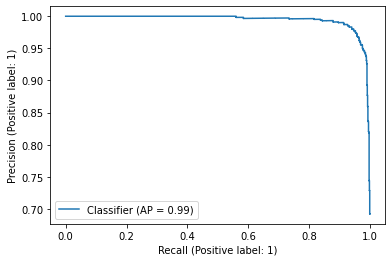

In [102]:
evaluate_preds(predictions[klass], y_test[klass], tresholds)

### 6 - класс

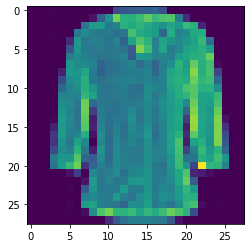

6


In [103]:
n = labels.index(6)
plt.imshow(images[n,:,:])
plt.show()
print(labels[n])

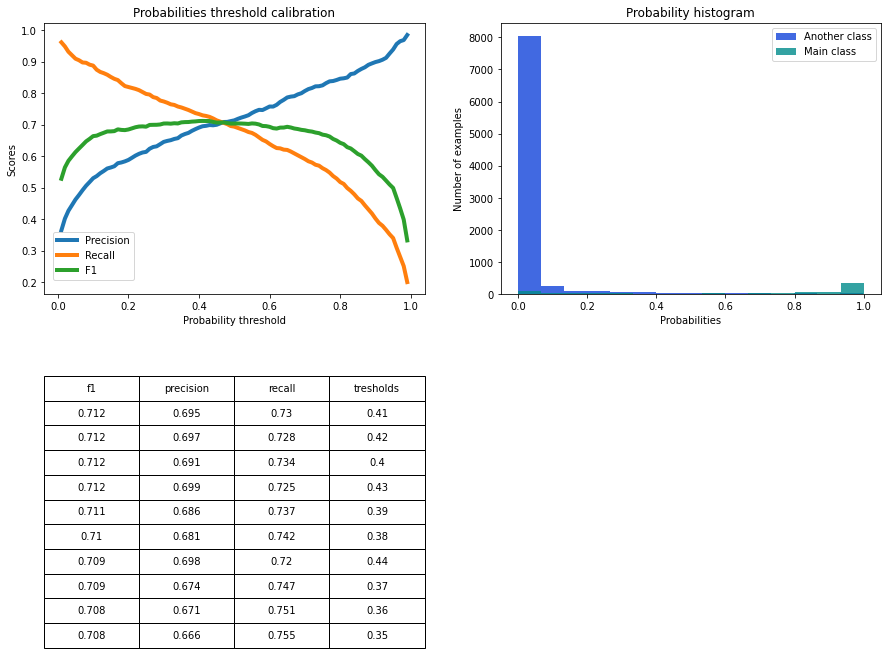

In [104]:
klass = labels[n]
roc_auc, f_score, precision, recall,  tresholds = show_proba_calibration_plots(predictions[klass], y_test[klass])

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      9000
         1.0       0.70      0.73      0.71      1000

    accuracy                           0.94     10000
   macro avg       0.83      0.85      0.84     10000
weighted avg       0.94      0.94      0.94     10000



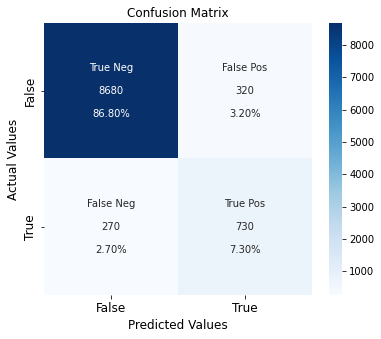

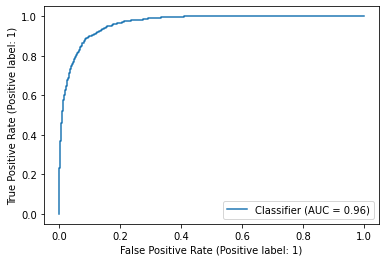

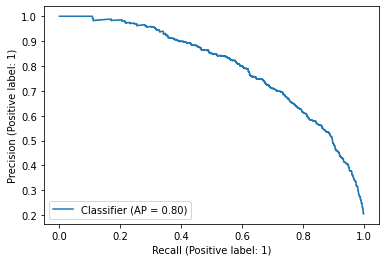

In [105]:
evaluate_preds(predictions[klass], y_test[klass], tresholds)

### 7 - класс

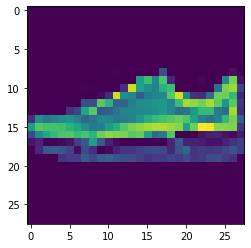

7


In [106]:
n = labels.index(7)
plt.imshow(images[n,:,:])
plt.show()
print(labels[n])

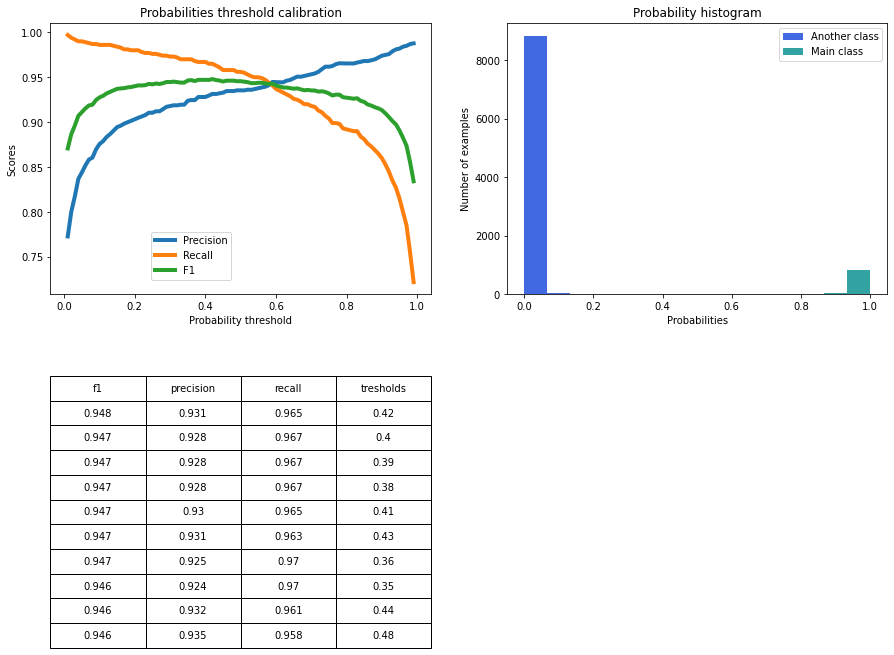

In [107]:
klass = labels[n]
roc_auc, f_score, precision, recall,  tresholds = show_proba_calibration_plots(predictions[klass], y_test[klass])

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      9000
         1.0       0.93      0.96      0.95      1000

    accuracy                           0.99     10000
   macro avg       0.96      0.98      0.97     10000
weighted avg       0.99      0.99      0.99     10000



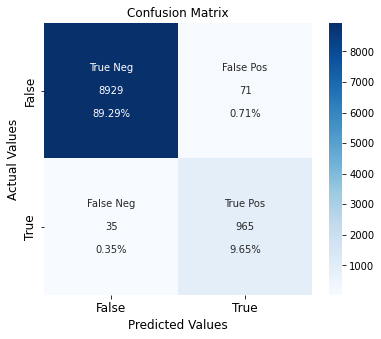

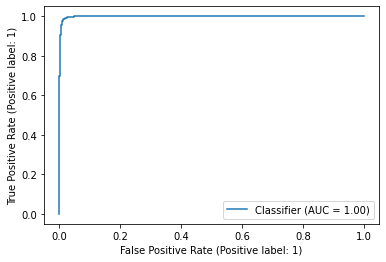

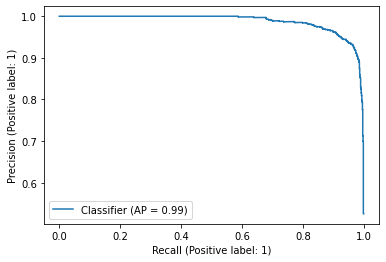

In [108]:
evaluate_preds(predictions[klass], y_test[klass], tresholds)

### 8 - класс

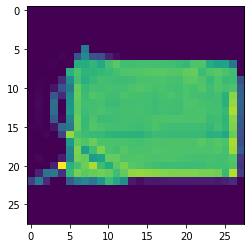

8


In [109]:
n = labels.index(8)
plt.imshow(images[n,:,:])
plt.show()
print(labels[n])

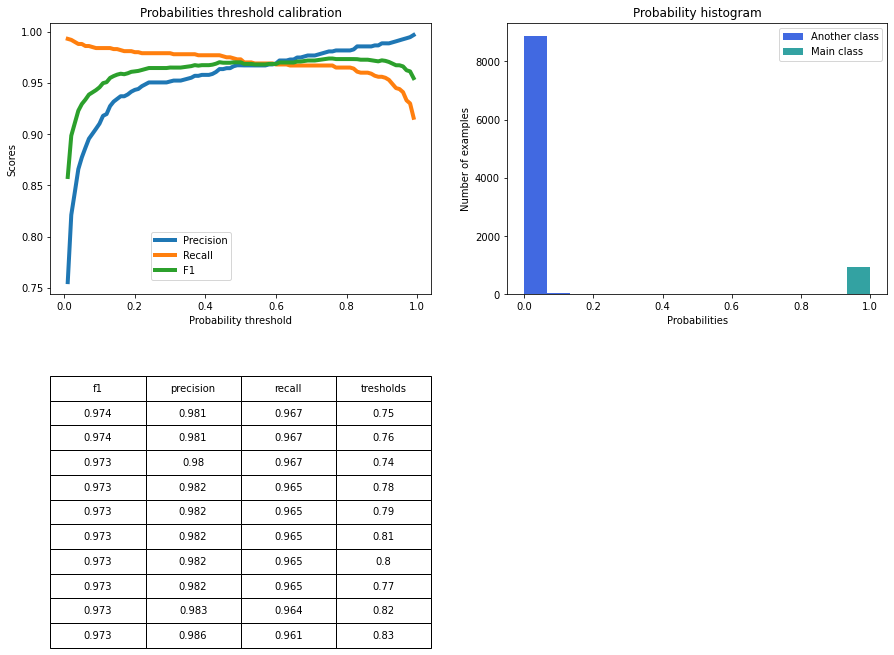

In [110]:
klass = labels[n]
roc_auc, f_score, precision, recall,  tresholds = show_proba_calibration_plots(predictions[klass], y_test[klass])

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9000
         1.0       0.98      0.97      0.97      1000

    accuracy                           0.99     10000
   macro avg       0.99      0.98      0.99     10000
weighted avg       0.99      0.99      0.99     10000



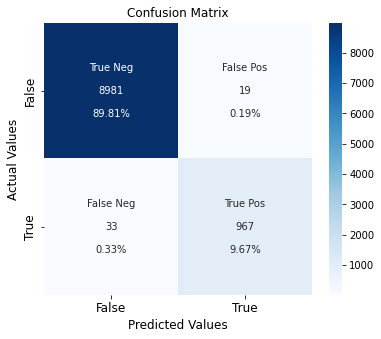

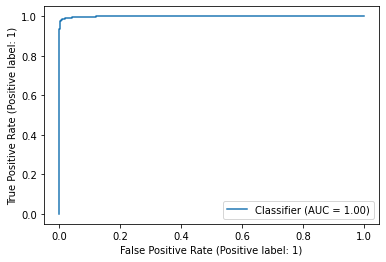

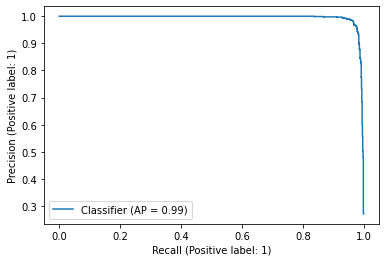

In [111]:
evaluate_preds(predictions[klass], y_test[klass], tresholds)

### 9 - класс

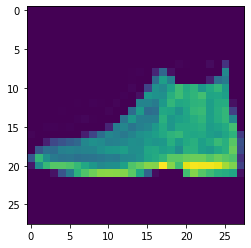

9


In [112]:
n = labels.index(9)
plt.imshow(images[n,:,:])
plt.show()
print(labels[n])

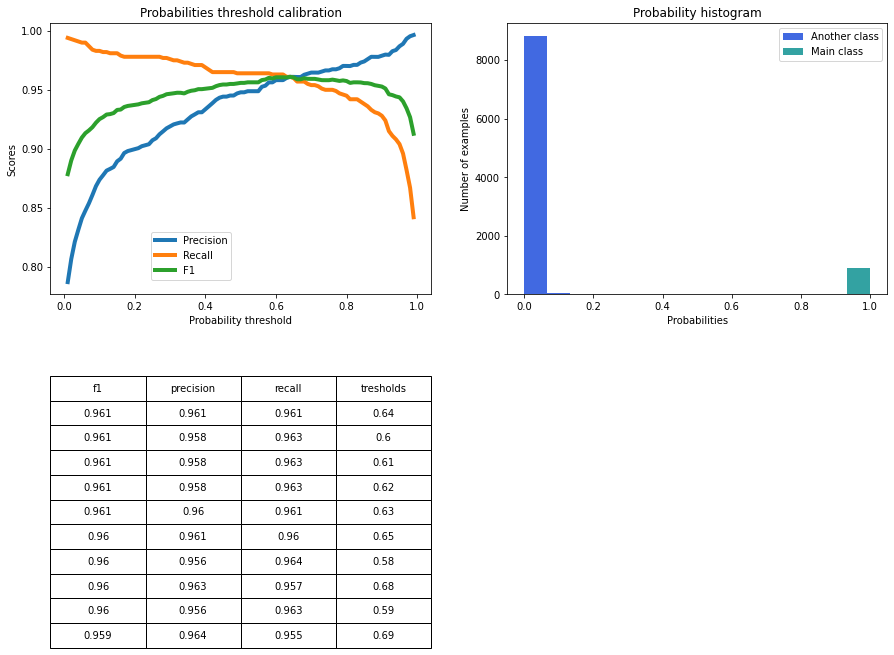

In [113]:
klass = labels[n]
roc_auc, f_score, precision, recall,  tresholds = show_proba_calibration_plots(predictions[klass], y_test[klass])

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9000
         1.0       0.96      0.96      0.96      1000

    accuracy                           0.99     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



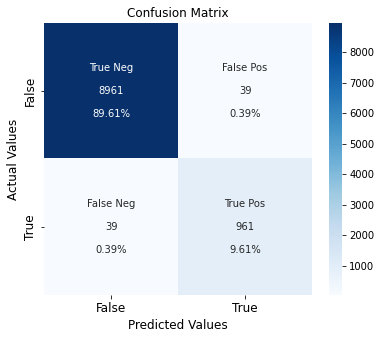

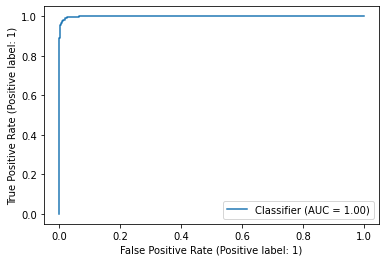

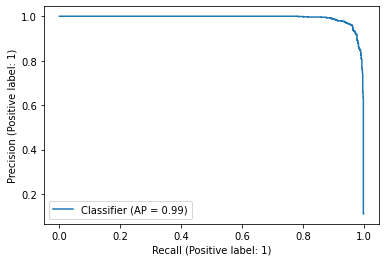

In [114]:
evaluate_preds(predictions[klass], y_test[klass], tresholds)